In [1]:
import os
import joblib
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from skimage.feature import local_binary_pattern
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

####  Basic Image processing ->
**Image Resizing** : Resizing images to a consistent size ensures uniformity in feature extraction and reduces computational complexity.  "cv.resize()" is used to resize the input image to a specified width and height (in this case, 150x150 pixels).

**Color Space Conversion (Grayscale):**: Converting images to grayscale simplifies subsequent processing by reducing color information to a single channel. "cv.cvtColor()" converts the resized image from the BGR color space to grayscale.

**Image Blurring (Gaussian Blur):**:  Gaussian blur is a form of image smoothing that reduces noise and enhances edge detection. "cv.GaussianBlur()" applies a Gaussian blur to the grayscale image using a specified kernel size (5x5 in this case).

In [2]:
def preprocess_image(image):
    resized_image = cv.resize(image, (150, 150))
    gray_image = cv.cvtColor(resized_image, cv.COLOR_BGR2GRAY)
    blurred_image = cv.GaussianBlur(gray_image, (5, 5), 0)
    return blurred_image

#### Feature Selection ->
**Color Histogram :** Color histograms represent the distribution of color intensities in an image and are commonly used as image descriptors. "cv.calcHist()" calculates the histogram of the input image, specifying the number of bins for each color channel (8 bins per channel in this case). Histogram bins define the range of values over which pixel intensities are grouped, while histogram ranges specify the minimum and maximum values for each channel.

**Edge Detection:** The Sobel operator computes the gradient of the image intensity, which represents the rate of change of intensity in the x and y directions. "cv.Sobel()" computes the gradient along the x and y directions separately using convolution with the Sobel kernels. The magnitude of the gradient is then computed using the Euclidean norm. Normalizing the gradient magnitude ensures that the values are within a certain range, making them suitable for further processing or visualization.

**Texture Detection:** Local Binary Patterns are texture descriptors used for texture classification and analysis.
Method: LBP encodes the local structure of an image by comparing each pixel with its surrounding neighbors. It assigns a binary code to each pixel based on whether its intensity is greater than or less than that of the surrounding neighbors.The radius parameter determines the radius of the circular neighborhood around each pixel, while n_points specifies the number of sampling points within the neighborhood.

**Entropy:** Entropy measures the amount of uncertainty or disorder in an image. In image processing, entropy can be used as a measure of texture complexity or randomness. Ensuring numerical stability is crucial when performing calculations involving small or very large values, as these can lead to numerical errors or instability.
Method: Adding a small constant (e.g., 1𝑒 − 10 ) to the image intensities before computing the logarithm helps prevent division by zero or taking the logarithm of zero, which can result in undefined or NaN (Not a Number) values.

**Gradients:** The Histogram of Oriented Gradients is a feature descriptor used for object detection and image classification tasks. HOG computes the gradient magnitude and orientation for small regions (cells) in the image and constructs histograms of gradient orientations within larger blocks. These histograms capture the local gradient structure and are concatenated to form the final feature vector.

**Corner Detection:** Identify points in an image where the intensity variation converges in two or more directions, indicating the presence of a corner or an edge intersection.
Method: cv.cornerHarris() is one such algorithm that computes a Harris corner response function for each pixel, indicating the likelihood of that pixel being part of a corner.

In [3]:
def extract_histogram(image):
    # Extract color histogram features
    hist = cv.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    return hist.flatten()

def extract_sobel_edges(image):
    sobelx = cv.Sobel(image, cv.CV_64F, 1, 0, ksize=5)
    sobely = cv.Sobel(image, cv.CV_64F, 0, 1, ksize=5)
    sobel_combined = np.hypot(sobelx, sobely)
    sobel_combined = cv.normalize(sobel_combined, sobel_combined).flatten()
    return sobel_combined

def extract_lbp(image):
    # Extract Local Binary Patterns (LBP) features
    radius = 1
    n_points = 8 * radius
    lbp = local_binary_pattern(image, n_points, radius, method="uniform")
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins), density=True)
    return hist

def extract_entropy(image):
    entropy = -np.sum(image * np.log2(image + 1e-10))
    return np.array([entropy])

def extract_hog(image):
    # Extract Histogram of Oriented Gradients (HOG) features
    hog = cv.HOGDescriptor()
    h = hog.compute(image)
    return h.flatten() # type : ignore

def extract_corners(image):
    corners = cv.cornerHarris(image, 2, 3, 0.04)
    return corners.flatten()

| Image Type | Features Extracted                 |
|------------|------------------------------------|
| Buildings  | Sobel Edges, LBP, Color Histogram  |
| Forest     | LBP, Color Histogram               |
| Glacier    | Sobel Edges, Color Histogram       |
| Mountains  | Sobel Edges, LBP                   |
| Sea        | LBP, Color Histogram               |
| Streets    | Sobel Edges, LBP, Color Histogram  |


In [4]:
def extract_features_set1(image, image_type):
    processed_image = preprocess_image(image)
    color_image = cv.cvtColor(cv.resize(image, (150, 150)), cv.COLOR_BGR2RGB)
    combined_features = []
    if image_type == 'Buildings':
        edges = extract_sobel_edges(processed_image)
        texture = extract_lbp(processed_image)
        color_hist = extract_histogram(color_image)
        combined_features = np.hstack([edges, texture, color_hist])
    elif image_type == 'Forest':
        texture = extract_lbp(processed_image)
        color_hist = extract_histogram(color_image)
        combined_features = np.hstack([texture, color_hist])
    elif image_type == 'Glacier':
        edges = extract_sobel_edges(processed_image)
        color_hist = extract_histogram(color_image)
        combined_features = np.hstack([edges, color_hist])
    elif image_type == 'Mountains':
        edges = extract_sobel_edges(processed_image)
        texture = extract_lbp(processed_image)
        combined_features = np.hstack([edges, texture])
    elif image_type == 'Sea':
        texture = extract_lbp(processed_image)
        color_hist = extract_histogram(color_image)
        combined_features = np.hstack([texture, color_hist])
    elif image_type == 'Streets':
        edges = extract_sobel_edges(processed_image)
        texture = extract_lbp(processed_image)
        color_hist = extract_histogram(color_image)
        combined_features = np.hstack([edges, texture, color_hist])
    return combined_features



#### Image Loading and Processing ->

The load_and_preprocess_images() function iterates over the images in the specified folder, extracts features using the provided feature_set_extractor function, and computes the maximum feature vector length. Extracting features from images creates the feature vectors that will be used as input to the machine learning model. 

Features are extracted using the feature_set_extractor function, and the maximum feature vector length is computed based on the longest feature vector encountered during the extraction process.Encoding categorical labels as numerical values enables the use of machine learning algorithms that require numerical inputs. The LabelEncoder() class from scikit-learn is used to encode the categorical labels into numerical values.

FLOW OF OPERATION->

1. Initialize Variables:

    1. Initialize empty lists features and labels to store extracted features and corresponding labels.
    
    2. Set max_length to 0 to keep track of the maximum feature vector length encountered.

2. Feature Extraction and Maximum Length Calculation:

    1. Iterate over each category (subfolder) in the specified folder.

    2. For each image file in the category:
        1. Read the image using OpenCV (cv.imread()).
        2. Check if the image is valid (not None).
        3. Extract features from the image using the provided feature_set_extractor function.
        4. Append the feature vector to the features list.
        5. Append the category label to the labels list.
        6. Update max_length with the maximum length of the feature vector encountered so far.

3. Padding Feature Vectors:

    1. Iterate over each feature vector in the features list.
    2. Pad each feature vector with zeros to match the length of the longest feature vector (max_length).
    3. Update the corresponding feature vector in the features list with the padded feature vector.

4. Label Encoding:

    1. Encode the categorical labels (labels) into numerical values using LabelEncoder() from scikit-learn.
    2. Convert the features and labels lists to numpy arrays for compatibility with machine learning algorithms.

5. Return Results:
    
    Return the padded feature vectors (features), encoded labels (encoded_labels), and the label encoder (label_encoder) for later use in the training process.

In [5]:

def load_and_preprocess_images(folder, feature_set_extractor):
    features = []
    labels = []
    max_length = 0  # Initialize maximum length to zero
    
    # First pass: Extract features and find the maximum feature vector length
    for category in os.listdir(folder):
        category_path = os.path.join(folder, category)
        if os.path.isdir(category_path):
            for filename in os.listdir(category_path):
                img_path = os.path.join(category_path, filename)
                image = cv.imread(img_path)
                if image is not None:
                    feature_vector = feature_set_extractor(image, category)
                    features.append(feature_vector)
                    labels.append(category)
                    max_length = max(max_length, len(feature_vector))  # Update maximum length
    
    # Second pass: Pad feature vectors to the length of the longest vector
    for i in range(len(features)):
        features[i] = np.pad(features[i], (0, max_length - len(features[i])), mode='constant')
    # Encode labels
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    # Convert to numpy array
    features = np.array(features)
    encoded_labels = np.array(encoded_labels)
    
    return features, encoded_labels, label_encoder

#### PCA for Dimensionality Reduction ->

Principal Component Analysis (PCA) is used to reduce the dimensionality of the feature space while preserving as much variance as possible. PCA transforms the original features into a new set of orthogonal features (principal components) that capture the maximum variance in the data.

The explained variance ratio indicates the proportion of variance explained by each principal component. The cumulative explained variance ratio is plotted against the number of components to visualize how much variance is retained as the number of components increases.

Selecting a variance threshold determines the amount of variance to retain in the reduced feature space. The threshold is set based on the cumulative explained variance ratio plot, aiming to retain a certain percentage (e.g., 95%) of the total variance.

Evaluating model performance helps determine the optimal number of principal components for dimensionality reduction. Cross-validation is performed on the reduced feature space using a machine learning model (e.g., K-Nearest Neighbors) to estimate classification accuracy

FLOW OF OPERATION ->

1. Plot Explained Variance Ratio: 

    Visualize how much variance is retained with increasing number of components.

2. Determine n_components for Desired Variance Threshold: 
    
    Find the number of components needed to retain a specified variance threshold.

3. Perform Cross-Validation: 
    
    Evaluate model performance using cross-validation for different numbers of components.

4. Determine Optimal Number of Components: 

    Identify the number of components maximizing cross-validated accuracy.

5. Return Results: 
    
    Provide the optimal number of components for PCA dimensionality reduction.

In [6]:

def select_optimal_pca_components(features, labels, variance_threshold=0.95):
    # Step 1: Plot Explained Variance Ratio
    pca = PCA().fit(features)
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance vs Number of Components')
    plt.grid(True)
    plt.show()
    # Step 2: Determine n_components for desired variance threshold
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    print(f"Number of components to retain {variance_threshold*100}% variance: {n_components}")
    # Step 3: Perform Cross-Validation
    n_components_range = range(10, n_components + 50, 10)  # Adjust range based on your data
    mean_accuracies = []
    for n in n_components_range:
        pca = PCA(n_components=n)
        features_reduced = pca.fit_transform(features)
        knn = KNeighborsClassifier(n_neighbors=5)
        scores = cross_val_score(knn, features_reduced, labels, cv=5)  # 5-fold cross-validation
        mean_accuracies.append(scores.mean())
    plt.figure(figsize=(10, 6))
    plt.plot(n_components_range, mean_accuracies)
    plt.xlabel('Number of Components')
    plt.ylabel('Cross-Validated Accuracy')
    plt.title('Model Performance vs Number of Components')
    plt.grid(True)
    plt.show()
    optimal_n_components = n_components_range[np.argmax(mean_accuracies)]
    print(f"Optimal number of components: {optimal_n_components}")
    return optimal_n_components

##### Implementing the Image Processing and Feature Extraction ->

In [7]:
# Example usage
folder_path = 'dataset/dataset_full'
features_set3, labels_set3, label_encoder = load_and_preprocess_images(folder_path, extract_features_set1)

##### Implementing Auto n_Components Selection ->

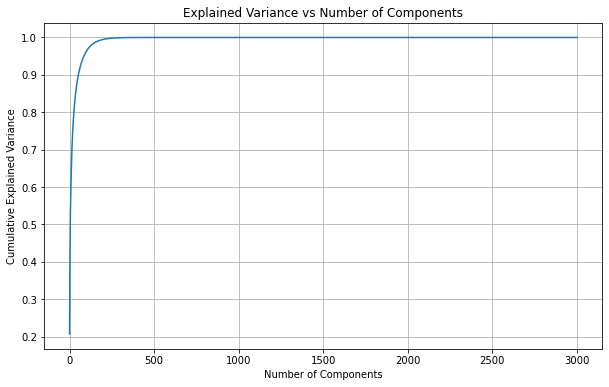

Number of components to retain 95.0% variance: 86


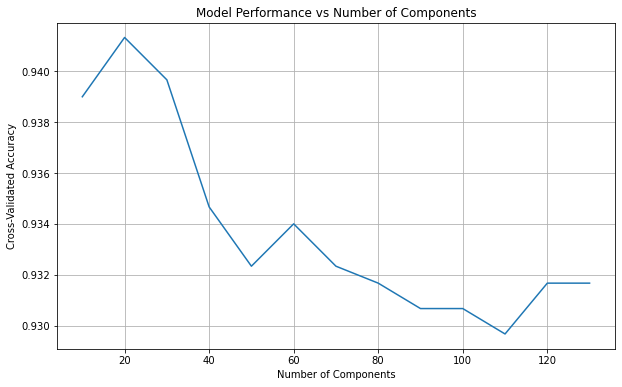

Optimal number of components: 20
Original Features shape -> (3000, 23022)
PCA Features shape -> (3000, 20)


In [8]:
# Select optimal n_components
optimal_n_components = select_optimal_pca_components(features_set3, labels_set3)
# Apply PCA with the optimal number of components
pca = PCA(n_components=optimal_n_components)
features_set3_reduced = pca.fit_transform(features_set3)
print("Original Features shape ->", features_set3.shape)
print("PCA Features shape ->", features_set3_reduced.shape)

##### Saving the PCA and Label Encoder Files ->

In [9]:
# Save the PCA model, label encoder, and trained KNN model
joblib.dump(pca, 'pca_model_optimal.pkl')
joblib.dump(label_encoder, 'label_encoder_pca.pkl')

['label_encoder_pca.pkl']

#### KNN - Model Training ->
Train a machine learning model (K-Nearest Neighbors in this case) on the provided features and labels and evaluate its performance. The function splits the data into training and testing sets, iterates over different values of the hyperparameter k, trains a KNN classifier with each value, and evaluates its performance on both training and testing data.

FLOW OF OPERATIONS ->

1. Data Splitting:

    Split the input features and labels into training and testing sets using a specified test size and random state.

2. Model Training and Evaluation:

    1. Evaluate the K-Nearest Neighbors (KNN) algorithm for different values of the hyperparameter k.

    2. Train a KNN classifier for each value of k and evaluate its performance on both training and testing data.
    
    3. Plot the training and testing accuracies against the number of neighbors (k) to visualize the model's behavior.

    4. Report the final training and testing accuracies, as well as other classification metrics such as precision, recall, and F1-score.

3. Model Saving:
    
    Serialize and save the trained KNN classifier to the specified file path for future use and deployment.

In [10]:
def train_and_save_model(features, labels, model_path):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    # Evaluate KNN for different values of k
    k_values = range(1, 21)  # Test k from 1 to 20
    train_accuracies = []
    test_accuracies = []

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        # Calculate training accuracy
        train_accuracy = accuracy_score(y_train, knn.predict(X_train))
        train_accuracies.append(train_accuracy)
        # Calculate test accuracy
        test_accuracy = accuracy_score(y_test, knn.predict(X_test))
        test_accuracies.append(test_accuracy)
    
    # Plotting the results
    plt.figure(figsize=(10, 5))
    plt.plot(k_values, train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(k_values, test_accuracies, label='Test Accuracy', marker='o')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Accuracy')
    plt.title('k-NN: Number of Neighbors vs. Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Final evaluation with k=4 (as in the original code)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    # Calculate training and test accuracy
    train_accuracy = accuracy_score(y_train, knn.predict(X_train))
    test_accuracy = accuracy_score(y_test, knn.predict(X_test))
    print(f"KNN with k= 5 - Training Accuracy: {train_accuracy:.4f}")
    print(f"KNN with k= 5 - Test Accuracy: {test_accuracy:.4f}")
    print("KNN Classification Report:\n", classification_report(y_test, knn.predict(X_test)))

    # Save the trained model
    joblib.dump(knn, model_path)
    print(f"Model saved to {model_path}")

**Model Implementation and Saving ->**

Training and saving the model for Feature Set 3:


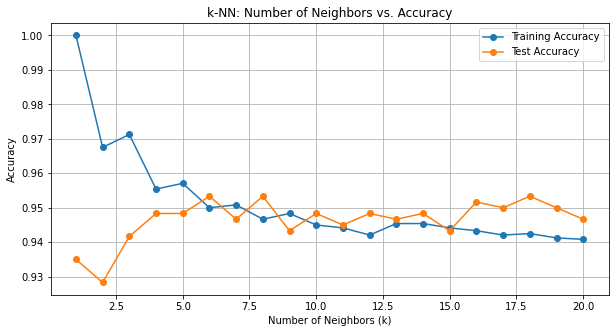

KNN with k= 5 - Training Accuracy: 0.9571
KNN with k= 5 - Test Accuracy: 0.9483
KNN Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       118
           1       0.87      0.90      0.89        99
           2       0.99      0.93      0.96        96
           3       0.99      1.00      1.00       101
           4       0.89      0.86      0.87        91
           5       0.94      0.99      0.96        95

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600

Model saved to knn_set3_pca.pkl


In [11]:
# Train and save the model
model_path = 'knn_set3_pca.pkl'
print("Training and saving the model for Feature Set 3:")
train_and_save_model(features_set3_reduced, labels_set3, model_path)